In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd

import numpy as np
from jax.config import config

config.update("jax_enable_x64", True)
import squidpy as sq
import scanpy as sc

%load_ext autoreload
%autoreload 2
%load_ext lab_black

DATA_DIR = Path("/lustre/groups/ml01/workspace/moscot_paper/spatiotemporal/mosta")

In [2]:
adata15 = sc.read(DATA_DIR / "E15.5_E1S1.MOSTA.h5ad")
adata16 = sc.read(DATA_DIR / "E16.5_E1S1.MOSTA.h5ad")

Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].


In [3]:
adata15.X = adata15.layers["count"].copy()
adata16.X = adata16.layers["count"].copy()
sc.pp.highly_variable_genes(adata15, flavor="seurat_v3", n_top_genes=5000, subset=False)
sc.pp.highly_variable_genes(adata16, flavor="seurat_v3", n_top_genes=5000, subset=False)

In [4]:
sc.pp.normalize_total(adata15)
sc.pp.normalize_total(adata16)
sc.pp.log1p(adata15)
sc.pp.log1p(adata16)
sc.pp.pca(adata15, n_comps=30)
sc.pp.pca(adata16, n_comps=30)
adata15.obs["time"] = "15"
adata16.obs["time"] = "16"

In [7]:
# adata16

In [9]:
import anndata as ad

adata = ad.concat([adata15, adata16], label="batch")

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/merge.py:863: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata.obs_names_make_unique()

In [24]:
adata15.obs_names

Index(['100_100', '100_101', '100_102', '100_103', '100_104', '100_105',
       '100_106', '100_107', '100_108', '100_109',
       ...
       '99_90', '99_91', '99_92', '99_93', '99_94', '99_95', '99_96', '99_97',
       '99_98', '99_99'],
      dtype='object', name='cell_name', length=113350)

In [83]:
# sc.pp.subsample(adata, fraction=0.01)
# used to test cell_transition, remove

In [25]:
adata.shape

(2351, 27840)

In [17]:
adata.obs["time"] = pd.Categorical(adata.obs["time"].astype(int))
adata.obs["annotation"] = pd.Categorical(adata.obs["annotation"])

In [18]:
adata.obs["annotation"].cat.categories

Index(['Adipose tissue', 'Adrenal gland', 'Blood vessel', 'Bone', 'Brain',
       'Cartilage', 'Cartilage primordium', 'Cavity', 'Choroid plexus',
       'Connective tissue', 'Dorsal root ganglion', 'Epidermis', 'GI tract',
       'Heart', 'Inner ear', 'Jaw and tooth', 'Kidney', 'Liver', 'Lung',
       'Meninges', 'Mucosal epithelium', 'Muscle', 'Olfactory epithelium',
       'Pancreas', 'Smooth muscle', 'Spinal cord', 'Submandibular gland',
       'Sympathetic nerve'],
      dtype='object')

In [19]:
from moscot.problems.spatio_temporal import SpatioTemporalProblem

stp = SpatioTemporalProblem(adata=adata).prepare(
    time_key="time",
    spatial_key="spatial",
    attr_joint=None,
    callback="local-pca",
    n_comps=30,
)

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'batch_size' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [20]:
stp.problems[(15, 16)].xy.data_y.shape

(1243, 30)

In [21]:
from datetime import datetime

start_time = datetime.now()
stp = stp.solve(alpha=0.01, epsilon=1e-3, rank=1000, jit=True)
end_time = datetime.now()

2022-07-25 11:28:50.747132: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 11:28:51.594204: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 11:28:52.527319: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [22]:
print(end_time - start_time)

0:02:59.555112


In [17]:
# adata.obs.annotation.cat.category

In [18]:
df = stp.cell_transition(
    start=15,
    end=16,
    early_annotation="annotation",
    late_annotation="annotation",
    forward=True,
    online=True,
    batch_size=1024,
)

2022-07-25 09:54:03.959394: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [19]:
import seaborn as sns

<AxesSubplot:>

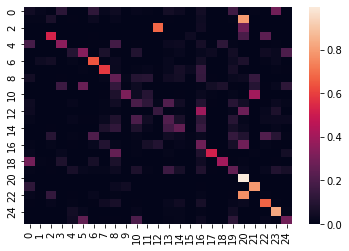

In [20]:
sns.heatmap(df.to_numpy())

In [27]:
adata.uns["spatial"] = {}

In [ ]:
stp.push()

In [45]:
adata[adata.obs.time == 16].shape

(1108, 27840)

In [78]:
df_cell = stp.cell_transition(
    start=15,
    end=16,
    early_annotation="annotation",
    late_annotation="annotation",
    aggregation_mode="cell",
    forward=False,
    online=True,
    batch_size=256,
)

2022-07-25 13:40:58.913932: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 13:40:59.638865: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-25 13:41:00.319041: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [84]:
df_cell.shape

(25, 1243)

In [81]:
np.testing.assert_array_equal(
    np.sort(adata[adata.obs.time == 16].obs_names.values),
    np.sort(df_cell.columns.values),
)

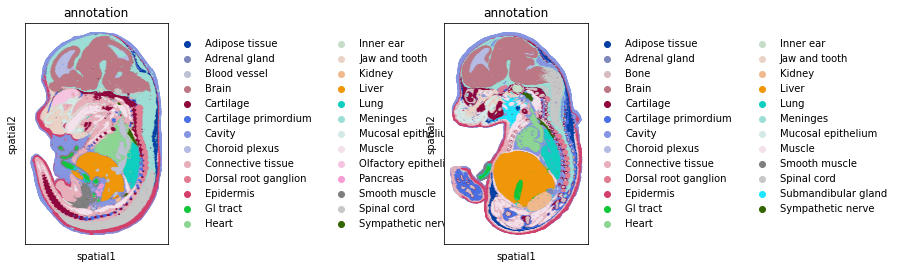

In [32]:
sq.pl.spatial_scatter(
    adata,
    library_key="time",
    library_id=[15, 16],
    color="annotation",
    shape=None,
    img=False,
)